In [115]:
# データセット作成

!pip install scipy

window_size = 1024
window_num_per_clip = 40
clip_size = window_size * window_num_per_clip

from scipy.io.wavfile import read
import glob
import os
import numpy as np

def standardization(x):
    return x / np.finfo(np.float64).max

if os.path.isfile("../data/arrays/clips.npy"):
    print("clips.npy exists.")
    clips = np.load("../data/arrays/clips.npy")
else:
    files = glob.glob("../data/wav44100/*")
    #files = ["../data/wav44100/3DEmbodimentFromLines.wav"]
    raw_data_list = [read(file)[1] for file in files]

    clips = np.zeros((0, clip_size), dtype=np.int16)
    for raw_data in raw_data_list:
        tmp = [raw_data[i:i + clip_size] for i in range(0, len(raw_data) - clip_size, clip_size)]
        clips = np.vstack((clips, np.array(tmp)))
    np.save("../data/arrays/clips", clips)
    
if os.path.isfile("../data/arrays/fft.npy"):
    print("fft.npy exists.")
    fft = np.load("../data/arrays/fft.npy")
else:
    fft = np.zeros((0, window_num_per_clip, window_size))
    for clip in clips:
        fft_tmp = np.zeros((0, window_size))
        tmp = [clip[i:i + window_size] for i in range(0, len(clip) - window_size + 1, window_size)]
        for tmp2 in tmp:
            spectrum = np.abs(np.fft.fft(tmp2))
            if np.max(spectrum) != 0:
                spectrum = softmax(spectrum)
            fft_tmp = np.vstack((fft_tmp, spectrum))
        fft = np.vstack((fft, fft_tmp.reshape(1, window_num_per_clip, window_size)))

    np.save("../data/arrays/fft", fft)

print(fft.shape)
print(type(fft[0][0][0]))
print(clips.shape)

print(fft[0][0])

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
(255, 40, 1024)
<class 'numpy.float64'>
(255, 40960)
[0. 0. 0. ... 0. 0. 0.]


In [116]:
# 学習データとテストデータに分ける

train_data_rate = 0.8

p = np.random.permutation(len(fft))
fft = fft[p]
clips = clips[p]

x_train = fft[:int(fft.shape[0] * train_data_rate), :, :].reshape((x_train.shape[0], clip_size))
x_test = fft[int(fft.shape[0] * train_data_rate):-1, :, :].reshape((x_test.shape[0], clip_size))
y_train = fft[1:int(fft.shape[0] * train_data_rate) + 1, 0, :]
y_test = fft[int(fft.shape[0] * train_data_rate) + 1:, 0, :]

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

print(np.max(x[0]))

(204, 40960)
(50, 40960)
(204, 1024)
(50, 1024)
0.47164425


In [117]:
def plot_history(history):
    # 精度の履歴をプロット
    plt.plot(history.history['accuracy'],"o-",label="accuracy")
    plt.plot(history.history['val_accuracy'],"o-",label="val_acc")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()
 
    # 損失の履歴をプロット
    plt.plot(history.history['loss'],"o-",label="loss",)
    plt.plot(history.history['val_loss'],"o-",label="val_loss")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='lower right')
    plt.show()

In [127]:
# モデル作成

import keras

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras.optimizers import RMSprop
 
model = keras.models.Sequential()
model.add(Dense(units=512,input_dim=clip_size))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(units=512,input_dim=clip_size))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1024))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

In [128]:
# 学習

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=50,
                    verbose=1,
                    validation_data=(x_test, y_test))

Epoch 1/50
2/2 [==============================] - 1s 240ms/step - loss: 6.8652 - accuracy: 0.0147 - val_loss: 5.9753 - val_accuracy: 0.0000e+00
Epoch 2/50
2/2 [==============================] - 0s 131ms/step - loss: 5.1025 - accuracy: 0.0196 - val_loss: 3.7751 - val_accuracy: 0.0600
Epoch 3/50
2/2 [==============================] - 0s 129ms/step - loss: 3.3926 - accuracy: 0.0882 - val_loss: 3.5310 - val_accuracy: 0.1600
Epoch 4/50
2/2 [==============================] - 0s 131ms/step - loss: 3.1355 - accuracy: 0.1373 - val_loss: 3.5747 - val_accuracy: 0.2000
Epoch 5/50
2/2 [==============================] - 0s 131ms/step - loss: 2.9253 - accuracy: 0.1618 - val_loss: 3.5440 - val_accuracy: 0.1600
Epoch 6/50
2/2 [==============================] - 0s 142ms/step - loss: 2.8606 - accuracy: 0.1716 - val_loss: 3.6599 - val_accuracy: 0.0000e+00
Epoch 7/50
2/2 [==============================] - 0s 133ms/step - loss: 2.6148 - accuracy: 0.2402 - val_loss: 3.6623 - val_accuracy: 0.0400
Epoch 8/50
2

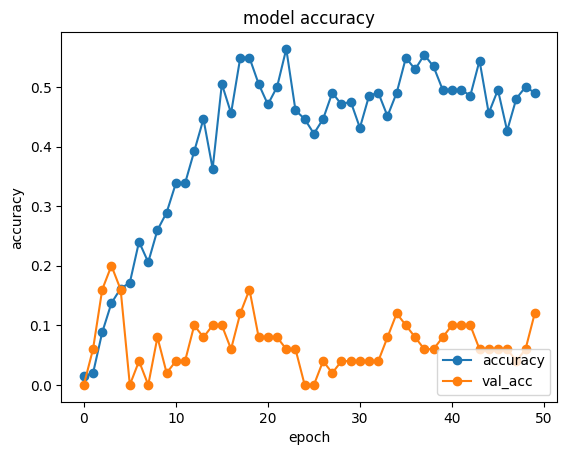

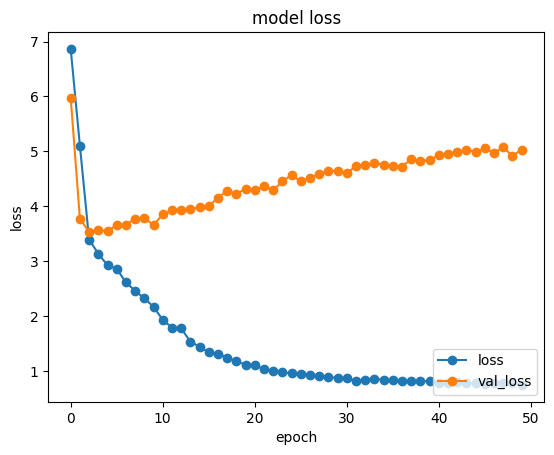

In [129]:
# loss 遷移のプロット

import matplotlib.pyplot as plt

plot_history(history)

In [144]:
# 楽曲の出力

!pip install scikit-learn

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from scipy.io import wavfile

first_index = 10
predict_index = first_index
out = np.zeros((0, ), dtype=np.int16)

for i in range(10):
    predict = model.predict(fft[predict_index].reshape(1, clip_size))
    
    index = 0
    similar_index = 0
    cos_sim = np.inf
    for spectrum in fft[:, 0:1, :]:
        tmp_sim = cosine_similarity(predict, spectrum) 
        if cos_sim > tmp_sim:
            cos_sim = tmp_sim
            similar_index = index
        index += 1
    
    print(similar_index)
    
    predict_index = similar_index
    out = np.hstack((out, clips[predict_index]))
    
wavfile.write("../data/out/fft_out.wav", 44100, out)

1/1 [==============================] - 0s 20ms/step
229
1/1 [==============================] - 0s 19ms/step
219
1/1 [==============================] - 0s 19ms/step
229
1/1 [==============================] - 0s 19ms/step
219
1/1 [==============================] - 0s 19ms/step
229
1/1 [==============================] - 0s 20ms/step
219
1/1 [==============================] - 0s 21ms/step
229
1/1 [==============================] - 0s 20ms/step
219
1/1 [==============================] - 0s 19ms/step
229
1/1 [==============================] - 0s 19ms/step
219
